# RNN with TensorFlow API

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

In [42]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        # 生成batch_size行，1列的数据（范围从0到1的浮点数）
        # 这个数据用作一系列数据的起点
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        # 转化成真实的起点
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        # 生成一个矩阵，有batch_size行，有steps列
        # 即：每一行是一个随机产生的batch
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        # 返回所有行的，0号元素到最后一个元素为RNN的输入
        # 向后移一位，作为RNN的输出
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [43]:
ts_data = TimeSeriesData(250,0,10)

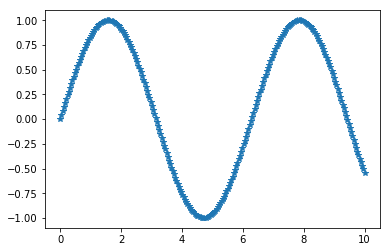

In [44]:
#生成一个x从0到10,250个点的sin图像
plt.plot(ts_data.x_data,ts_data.y_true, '*')

In [45]:
# Num of steps in batch (also used for prediction steps into the future)
# 产生30个点，（从上图中随机的取30个连续的点）
num_time_steps = 30

In [46]:
# 我们产生了一个batch的连续数字，每个batch的连续数字有num_time_steps个
# y2的点是y1的点后移一位而取得
# ts是y1所对应的x轴上的点
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

In [47]:
print(ts) #注意到我们只产生了一个batch的ts

[[ 3.76930997  3.80930997  3.84930997  3.88930997  3.92930997  3.96930997
   4.00930997  4.04930997  4.08930997  4.12930997  4.16930997  4.20930997
   4.24930997  4.28930997  4.32930997  4.36930997  4.40930997  4.44930997
   4.48930997  4.52930997  4.56930997  4.60930997  4.64930997  4.68930997
   4.72930997  4.76930997  4.80930997  4.84930997  4.88930997  4.92930997
   4.96930997]]


In [48]:
print(y1.flatten())
print(y2.flatten())

[-0.58729875 -0.61919515 -0.65010097 -0.67996677 -0.70874476 -0.73638892
 -0.76285501 -0.78810069 -0.81208559 -0.83477131 -0.85612159 -0.87610225
 -0.89468133 -0.91182911 -0.92751817 -0.94172339 -0.95442205 -0.96559384
 -0.97522089 -0.9832878  -0.98978165 -0.99469206 -0.99801118 -0.99973369
 -0.99985684 -0.99838044 -0.99530684 -0.99064096 -0.98439026 -0.97656475]
[-0.61919515 -0.65010097 -0.67996677 -0.70874476 -0.73638892 -0.76285501
 -0.78810069 -0.81208559 -0.83477131 -0.85612159 -0.87610225 -0.89468133
 -0.91182911 -0.92751817 -0.94172339 -0.95442205 -0.96559384 -0.97522089
 -0.9832878  -0.98978165 -0.99469206 -0.99801118 -0.99973369 -0.99985684
 -0.99838044 -0.99530684 -0.99064096 -0.98439026 -0.97656475 -0.96717695]


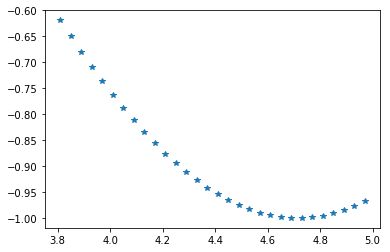

In [49]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

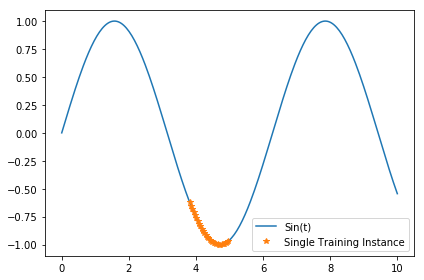

In [50]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

### A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [51]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

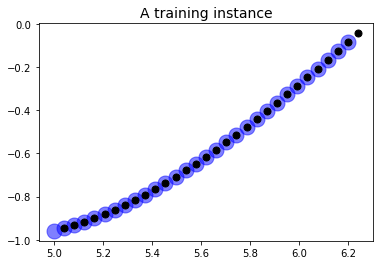

In [12]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

#浅色大圈是输入数据，深色小圈是输出数据

___________

# Creating the Model

In [13]:
tf.reset_default_graph()

### Constants

In [14]:
# Just one feature, the time series
num_inputs = 3
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

### Placeholders

In [15]:
#三维的tensor
#返回不定数目的（None）,[num_time_steps, num_inputs] 的二维matrix
# X.shape = （batch_size, num_of_time_steps, features）
# 本例中，time_steps = 30, features = 1
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

____
____
### RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [16]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [17]:
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)

In [18]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#           for layer in range(n_layers)])

In [19]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

In [20]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
#           for layer in range(n_layers)])

_____
_____

### Dynamic RNN Cell

In [21]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [22]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables

In [23]:
init = tf.global_variables_initializer()

## Session

In [24]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [25]:
saver = tf.train.Saver()

In [26]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps) #每次产生一次随机的序列
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

ValueError: Cannot feed value of shape (1, 30, 1) for Tensor 'Placeholder:0', which has shape '(?, 30, 3)'

### Predicting a time series t+1

In [27]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


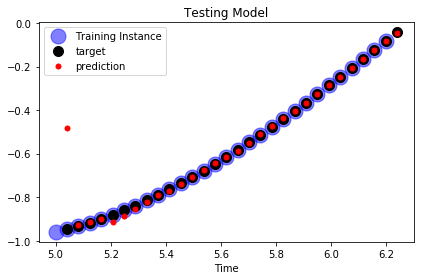

In [28]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequences
** Note: Can give wacky results sometimes, like exponential growth**

In [29]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


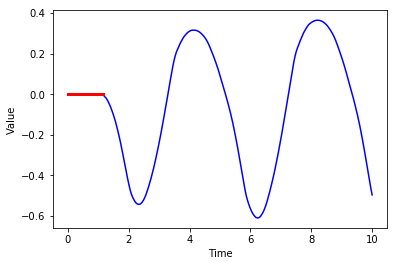

In [31]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [33]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


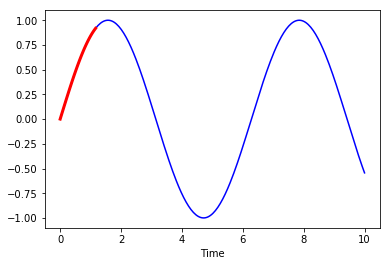

In [37]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")

# Great Job!